In [23]:
import pandas as pd
import calendar
import numpy as np 
# import statsmodels.api as sm 
# import os
# import sys
# import warnings 
# warnings.filterwarnings('ignore')
# import matplotlib.pyplot as pyplot 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
# from prophet import Prophet

In [6]:
# module_path = os.path.abspath(os.path.join('../'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
# import ds_utils as ds_ut
# import plot_utils as plt_ut
# project_dir = os.path.join(module_path, "Timeseries/")
# data_dir = project_dir+ 'data/'
# cur_dir = project_dir+ 'notebooks/'
# image_dir = project_dir+ 'images/'
# list_files = os.listdir(data_dir)

ModuleNotFoundError: No module named 'ds_utils'

In [2]:
file_path = 'data/JOG_monthly.csv'
data = pd.read_csv(file_path, delimiter=';')
#data = pd.read_csv(data_dir + 'JOGJA_monthly.csv', sep=';')
data.index = pd.to_datetime(data['THBL'], format='%Y%m')
data.drop(columns='THBL', inplace=True)
data.head()

,GWH_JUAL
THBL,
2015-01-01,201.535993
2015-02-01,184.068578
2015-03-01,205.282188
2015-04-01,205.318231
2015-05-01,214.088879


In [3]:
from pycaret.datasets import get_data 
from pycaret.time_series import *


ModuleNotFoundError: No module named 'pycaret'

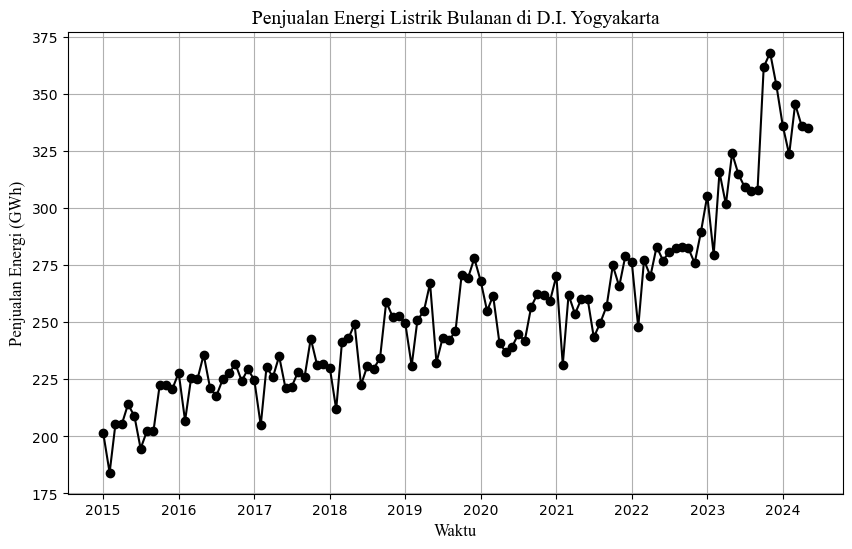

In [6]:
plt.figure(figsize=(10, 6))  # Menyesuaikan ukuran plot
plt.plot(data.index, data['GWH_JUAL'], marker='o', linestyle='-', color='k')  # Plotting dengan marker

# Menambahkan judul dan label sumbu
plt.title('Penjualan Energi Listrik Bulanan di D.I. Yogyakarta', fontname='Times New Roman', fontsize=14)
plt.xlabel('Waktu', fontname='Times New Roman', fontsize=12)
plt.ylabel('Penjualan Energi (GWh)', fontname='Times New Roman', fontsize=12)

# Menambahkan grid
plt.grid(True)

# Menampilkan plot
plt.show()

In [7]:
data['date'] = data.index.date
data['year'] = data.index.year
data['quarter'] = data.index.quarter
data['month'] = data.index.month

In [8]:
data.head()

,GWH_JUAL,date,year,quarter,month
THBL,,,,,
2015-01-01,201.535993,2015-01-01,2015,1,1
2015-02-01,184.068578,2015-02-01,2015,1,2
2015-03-01,205.282188,2015-03-01,2015,1,3
2015-04-01,205.318231,2015-04-01,2015,2,4
2015-05-01,214.088879,2015-05-01,2015,2,5


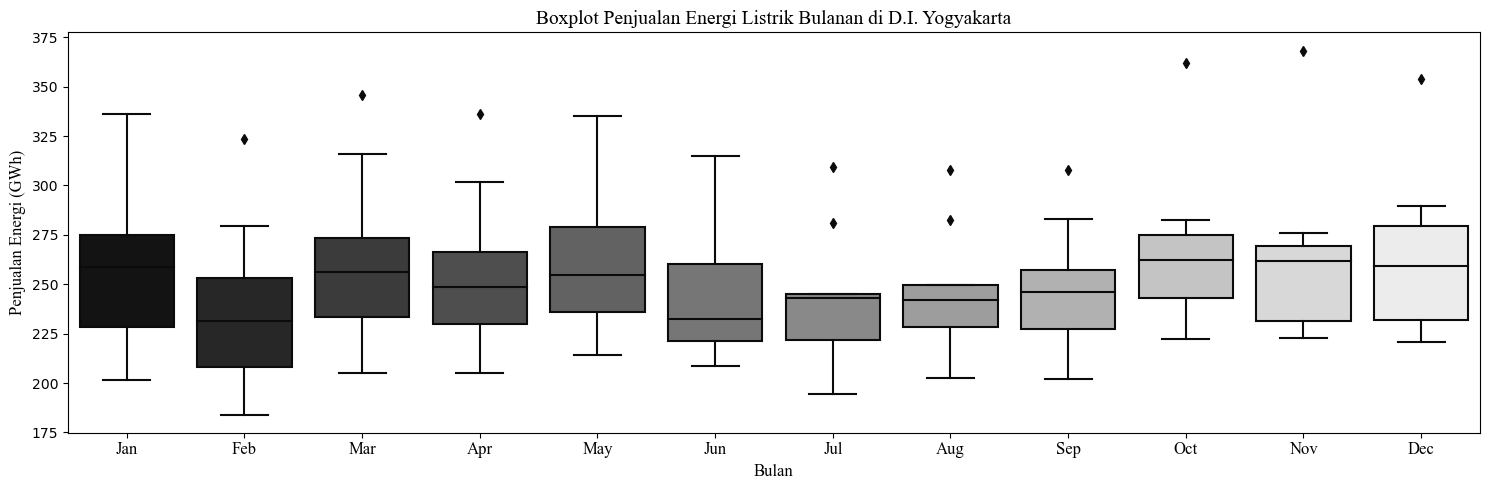

In [11]:
import seaborn as sns 
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x='month', y='GWH_JUAL', data=data, ax=ax, palette='gray')

months = [calendar.month_name[m][:3].title() for m in range(1, 13)]

ax.set_title('Boxplot Penjualan Energi Listrik Bulanan di D.I. Yogyakarta', fontname='Times New Roman', fontsize=14)
ax.set_xlabel('Bulan', fontname='Times New Roman', fontsize=12)
ax.set_ylabel('Penjualan Energi (GWh)', fontname='Times New Roman', fontsize=12)

ax.set_xticklabels(months, fontname='Times New Roman', fontsize=12)

# Menampilkan plot
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frekuensi')

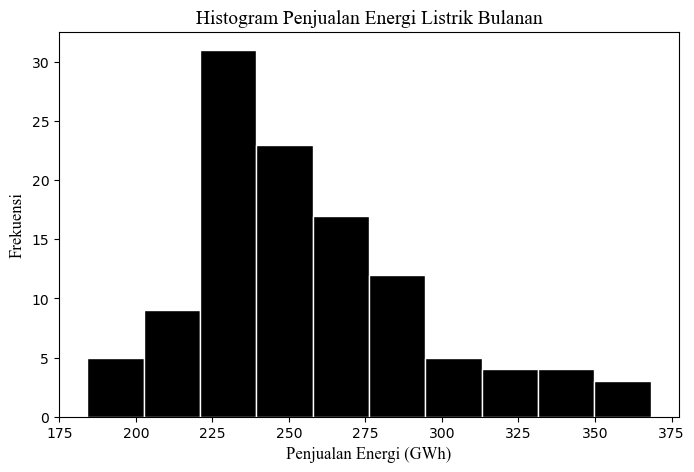

In [12]:
plt.figure(figsize=(8, 5))
plt.hist(data['GWH_JUAL'], bins=10, color='black', edgecolor='white')  # Ubah bins sesuai kebutuhan

# Menambahkan judul dan label sumbu
plt.title('Histogram Penjualan Energi Listrik Bulanan', fontname='Times New Roman', fontsize=14)
plt.xlabel('Penjualan Energi (GWh)', fontname='Times New Roman', fontsize=12)
plt.ylabel('Frekuensi', fontname='Times New Roman', fontsize=12)

# ACF 

In [13]:
def compute_acf(x, lags):
    n = len(x)
    mean = np.mean(x)
    acf = []
    for lag in range(lags + 1):
        c0 = np.sum((x - mean) ** 2) / n
        c1 = np.sum((x[:n-lag] - mean) * (x[lag:] - mean)) / n
        acf.append(c1 / c0)
    return np.array(acf)

In [16]:
sales = data['GWH_JUAL'].values
lags = min(24, len(sales) - 1)  # Pastikan lags tidak lebih besar dari panjang data
acf_values = compute_acf(sales, lags)

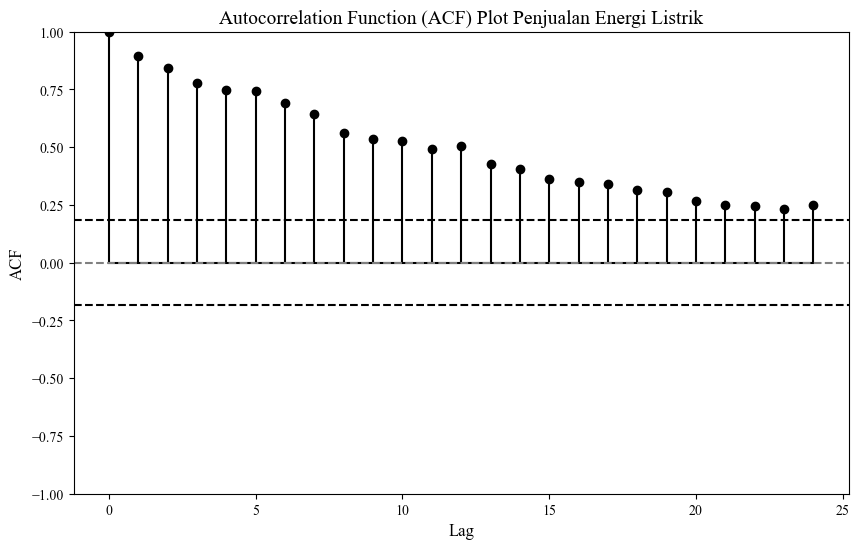

In [17]:
plt.figure(figsize=(10, 6))
markerline, stemlines, baseline = plt.stem(range(lags + 1), acf_values)
plt.setp(markerline, color='black')  # Set marker line color to black
plt.setp(stemlines, color='black')  # Set stem lines color to black
plt.setp(baseline, color='black')   # Set baseline color to black
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(sales)), linestyle='--', color='black')
plt.axhline(y=-1.96/np.sqrt(len(sales)), linestyle='--', color='black')
plt.ylim([-1, 1])
plt.xlabel('Lag', fontname='Times New Roman', fontsize=12)
plt.ylabel('ACF', fontname='Times New Roman', fontsize=12)
plt.title('Autocorrelation Function (ACF) Plot Penjualan Energi Listrik', fontname='Times New Roman', fontsize=14)
plt.xticks(fontname='Times New Roman', fontsize=10)
plt.yticks(fontname='Times New Roman', fontsize=10)
plt.show()


# PACF

In [18]:
def autocorrelation(series, lag):
    n = len(series)
    mean = np.mean(series)
    c0 = np.sum((series - mean) ** 2) / n
    c1 = np.sum((series[:n-lag] - mean) * (series[lag:] - mean)) / n
    return c1 / c0

In [19]:
def levinson_durbin(acf, nlags):
    pacf = np.zeros(nlags + 1)  # Inisialisasi array kosong untuk PACF dengan ukuran nlags + 1
    pacf[0] = 1  # PACF pada lag 0 adalah 1
    phi = np.zeros(nlags + 1)  # Inisialisasi array kosong untuk koefisien phi
    v = acf[0]  # Varians awal diatur ke nilai ACF pada lag 0

    for k in range(1, nlags + 1):  # Loop dari lag 1 hingga nlags
        phi[k] = acf[k] - np.dot(phi[1:k], acf[1:k][::-1])  # Hitung koefisien phi menggunakan ACF dan koefisien phi sebelumnya
        phi[k] /= v  # Bagi koefisien phi dengan varians saat ini
        v *= (1 - phi[k] ** 2)  # Update varians
        phi[1:k] -= phi[k] * phi[1:k][::-1]  # Update koefisien phi sebelumnya
        pacf[k] = phi[k]  # Simpan koefisien phi ke dalam array PACF

    return pacf  # Kembalikan array PACF

In [20]:
def compute_pacf(x, lags):
    acf_values = compute_acf(x, lags)
    pacf_values = levinson_durbin(acf_values, lags)
    return pacf_values

In [21]:
pacf_values = compute_pacf(sales, lags)

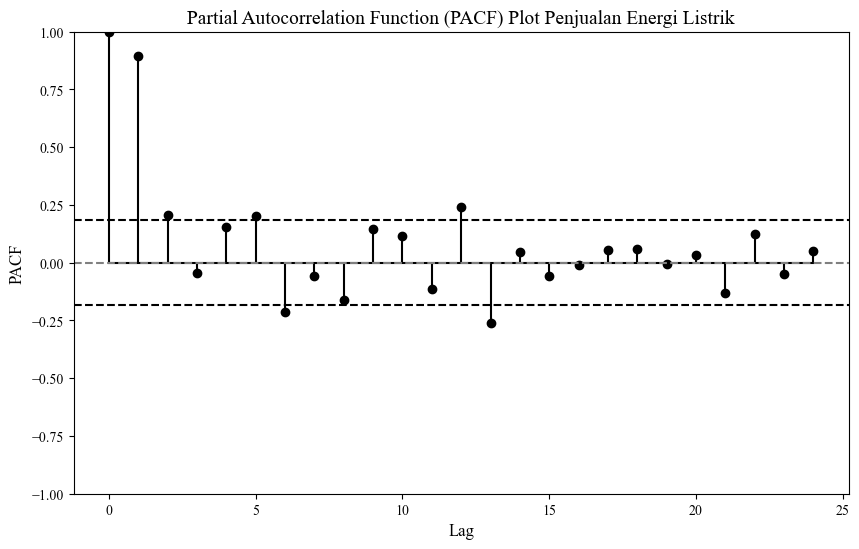

In [22]:
plt.figure(figsize=(10, 6))
markerline, stemlines, baseline = plt.stem(range(lags + 1), pacf_values)
plt.setp(markerline, color='black')  # Set marker line color to black
plt.setp(stemlines, color='black')  # Set stem lines color to black
plt.setp(baseline, color='black')   # Set baseline color to black
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(sales)), linestyle='--', color='black')
plt.axhline(y=-1.96/np.sqrt(len(sales)), linestyle='--', color='black')
plt.ylim([-1, 1])
plt.xlabel('Lag', fontname='Times New Roman', fontsize=12)
plt.ylabel('PACF', fontname='Times New Roman', fontsize=12)
plt.title('Partial Autocorrelation Function (PACF) Plot Penjualan Energi Listrik', fontname='Times New Roman', fontsize=14)
plt.xticks(fontname='Times New Roman', fontsize=10)
plt.yticks(fontname='Times New Roman', fontsize=10)
plt.show()


In [8]:
#Melaukan uji statistik 
check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,113.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,254.802586
3,Summary,Statistics,Transformed,Median,,247.832538
4,Summary,Statistics,Transformed,Standard Deviation,,38.091072
5,Summary,Statistics,Transformed,Variance,,1450.929735
6,Summary,Statistics,Transformed,Kurtosis,,0.613733
7,Summary,Statistics,Transformed,Skewness,,0.922793
8,Summary,Statistics,Transformed,# Distinct Values,,113.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",829.37678


In [7]:
s = setup(data, fh = 3, session_id = 123)

,Description,Value
0,session_id,123
1,Target,GWH_JUAL
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(113, 1)"
5,Transformed data shape,"(113, 1)"
6,Transformed train set shape,"(110, 1)"
7,Transformed test set shape,"(3, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


# ADF Test

In [24]:
result = adfuller(data['GWH_JUAL'])

# Menampilkan semua hasil
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Lags Used: {result[2]}')
print(f'Number of Observations Used: {result[3]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')
print(f'IC Best: {result[5]}')

# Membuat keputusan berdasarkan hasil uji
if result[1] > 0.05:
    print('Series is not stationary')
else:
    print('Series is stationary')

Test Statistics: 1.225010816159008
p-value: 0.9961542098492642
Lags Used: 12
Number of Observations Used: 100
Critical Values:
   1%: -3.497501033
   5%: -2.89090644
   10%: -2.5824349
IC Best: 770.9203827988472
Series is not stationary


# Proses Differencing 

In [25]:
data['GWH_JUAL_diff'] = data['GWH_JUAL'].diff()
data['GWH_JUAL_diff2'] = data ['GWH_JUAL_diff'].diff()


# Plot Differencing 

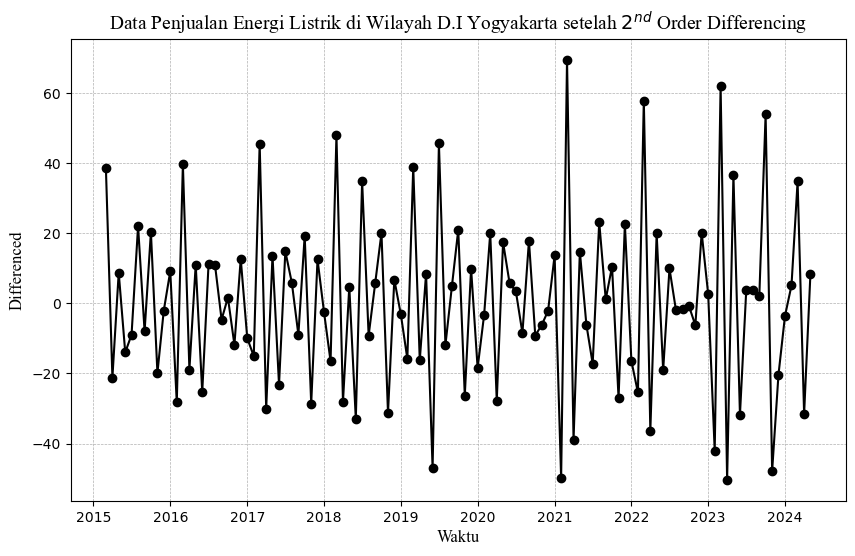

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['GWH_JUAL_diff2'], color='black', linestyle='-', marker='o')

# Adding labels and title
plt.xlabel('Waktu', fontname='Times New Roman', fontsize=12)
plt.ylabel('Differenced', fontname='Times New Roman', fontsize=12)
plt.title(r'Data Penjualan Energi Listrik di Wilayah D.I Yogyakarta setelah $2^{nd}$ Order Differencing', fontname='Times New Roman', fontsize=14)
# Adding grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show plot
plt.show()

# ADF setelah 2nd Order Differencing

In [27]:
data.dropna(subset=['GWH_JUAL_diff2'], inplace=True)
print(data)

              GWH_JUAL        date  year  quarter  month  GWH_JUAL_diff  \
THBL                                                                      
2015-03-01  205.282188  2015-03-01  2015        1      3      21.213610   
2015-04-01  205.318231  2015-04-01  2015        2      4       0.036043   
2015-05-01  214.088879  2015-05-01  2015        2      5       8.770648   
2015-06-01  208.853671  2015-06-01  2015        2      6      -5.235208   
2015-07-01  194.641206  2015-07-01  2015        3      7     -14.212465   
...                ...         ...   ...      ...    ...            ...   
2024-01-01  336.318057  2024-01-01  2024        1      1     -17.779362   
2024-02-01  323.638639  2024-02-01  2024        1      2     -12.679418   
2024-03-01  345.739468  2024-03-01  2024        1      3      22.100830   
2024-04-01  336.302055  2024-04-01  2024        2      4      -9.437414   
2024-05-01  335.301660  2024-05-01  2024        2      5      -1.000395   

            GWH_JUAL_dif

In [28]:
result = adfuller(data['GWH_JUAL_diff2'])

# Menampilkan semua hasil
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Lags Used: {result[2]}')
print(f'Number of Observations Used: {result[3]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')
print(f'IC Best: {result[5]}')

# Membuat keputusan berdasarkan hasil uji
if result[1] > 0.05:
    print('Series is not stationary')
else:
    print('Series is stationary')

Test Statistics: -5.600087014835886
p-value: 1.2706228591234838e-06
Lags Used: 13
Number of Observations Used: 97
Critical Values:
   1%: -3.4996365338407074
   5%: -2.8918307730370025
   10%: -2.5829283377617176
IC Best: 762.8671983901621
Series is stationary


# Time Series Decomposition 

In [31]:
result = seasonal_decompose(data['GWH_JUAL'], model='multiplikatif', period=12)
trend = result.trend
seasonal = result.seasonal
residual = result.resid

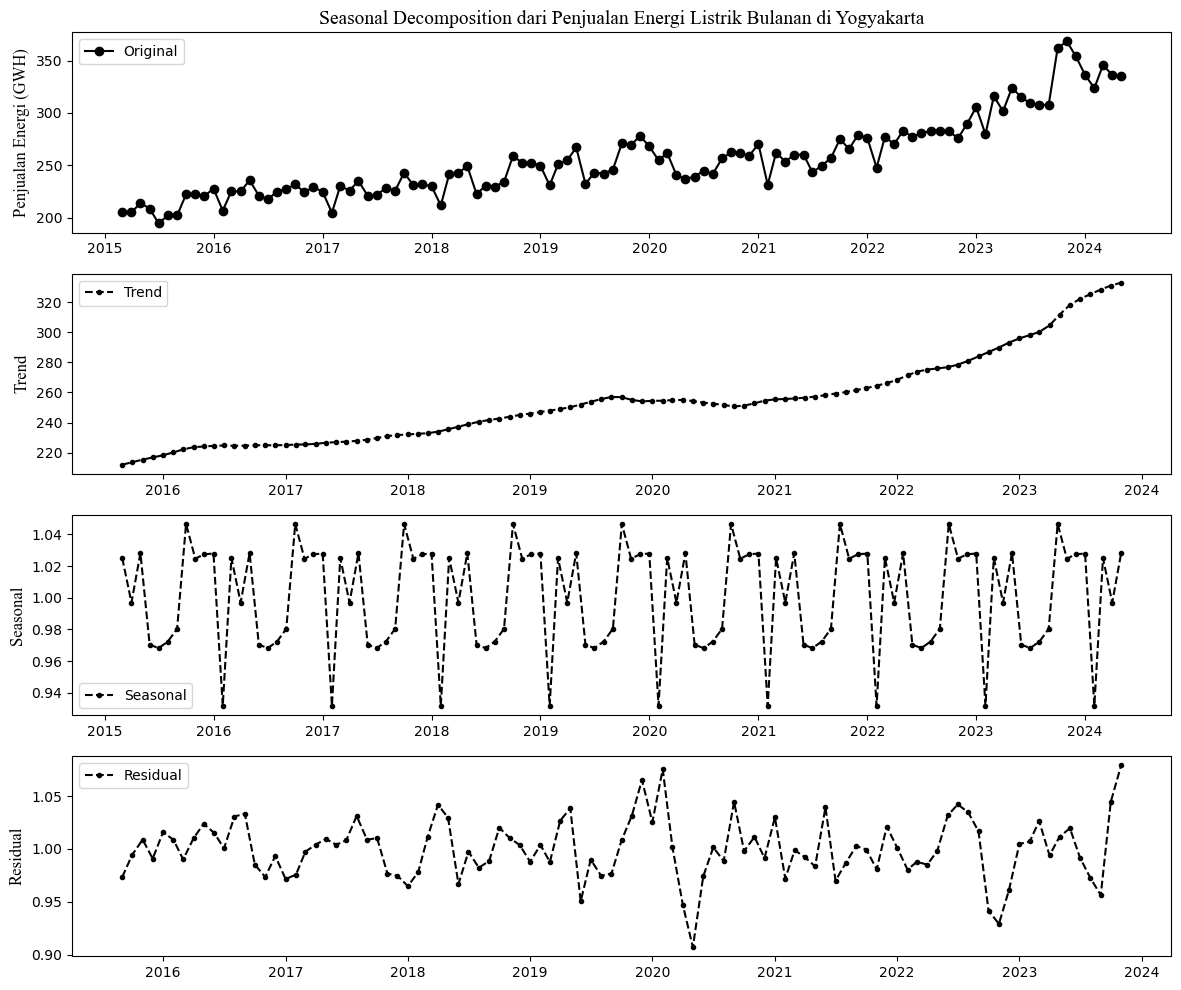

In [32]:
plt.figure(figsize=(12, 10))

# Plot data asli dengan garis putus-putus
plt.subplot(4, 1, 1)
plt.plot(data.index, data['GWH_JUAL'], linestyle='-', marker='o', color='black', label='Original')
plt.legend()
plt.ylabel('Penjualan Energi (GWH)', fontsize=12, fontname='Times New Roman')
plt.title('Seasonal Decomposition dari Penjualan Energi Listrik Bulanan di Yogyakarta', fontsize=14, fontname='Times New Roman')

# Plot trend dengan garis putus-putus
plt.subplot(4, 1, 2)
plt.plot(data.index, trend, linestyle='--', marker='.', color='black', label='Trend')
plt.legend()
plt.ylabel('Trend', fontsize=12, fontname='Times New Roman')

# Plot seasonal dengan garis putus-putus
plt.subplot(4, 1, 3)
plt.plot(data.index, seasonal, linestyle='--', marker='.', color='black', label='Seasonal')
plt.legend()
plt.ylabel('Seasonal', fontsize=12, fontname='Times New Roman')

# Plot residual dengan garis putus-putus
plt.subplot(4, 1, 4)
plt.plot(data.index, residual, linestyle='--', marker='.', color='black', label='Residual')
plt.legend()
plt.ylabel('Residual', fontsize=12, fontname='Times New Roman')

# Mengatur layout keseluruhan
plt.tight_layout()

# Menampilkan plot
plt.show()

In [9]:
best = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
stlf,STLF,1.1839,1.1131,17.3544,20.2735,0.0493,0.0518,-1.4631,0.1667
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,1.2003,1.1671,17.4735,21.0219,0.0500,0.0528,-4.0788,0.2700
ets,ETS,1.2153,1.0966,18.2359,20.7435,0.0528,0.0532,-2.3315,0.4000
exp_smooth,Exponential Smoothing,1.2160,1.0971,18.2474,20.7545,0.0528,0.0533,-2.3355,0.3200
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.2295,1.1610,17.7576,20.7243,0.0513,0.0540,-6.1486,0.3233
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,1.2296,1.1610,17.7583,20.7248,0.0513,0.0540,-6.1493,0.3367
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.2347,1.1652,17.8446,20.8306,0.0515,0.0542,-5.3169,3.0033
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,1.2348,1.1653,17.8458,20.8314,0.0515,0.0542,-5.3220,0.2767
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,1.2355,1.1655,17.8473,20.8125,0.0515,0.0542,-5.9394,0.8833
theta,Theta Forecaster,1.2359,1.1180,18.5298,21.1179,0.0536,0.0542,-2.6567,0.1033


In [10]:
plot_model(best, plot = 'forecast')

In [10]:
# instample plot, digunakan untuk melihat bagaimana model mempelajari dan meniru pola data

plot_model(best, plot = 'insample')

In [12]:
#residuals plot 
plot_model(best, plot = 'residuals')